In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as Ft
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from time import sleep
from IPython.display import display, update_display, clear_output
from random import choices, randint, uniform
from string import ascii_letters
import ipywidgets as widgets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import csv
from concurrent.futures import ThreadPoolExecutor
from torchviz import make_dot

In [2]:
class LengthAwareGenerator:
    def __init__(self, generator_fun, length, batch_size):
        self.generator = None
        self.generator_fun = generator_fun
        self.batch_size = batch_size
        self.length = length
        self.index = 0

    def __iter__(self):
        self.generator = self.generator_fun(self.length, self.batch_size)
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.length:
            self.index += 1
            return next(self.generator)
        else:
            raise StopIteration()

    def __len__(self):
        return (self.length + self.batch_size - 1) // self.batch_size

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.enc_fc1 = nn.Linear(64*15*15, latent_dim)
        self.enc_fc2 = nn.Linear(64*15*15, latent_dim)
        
        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim, 128*15*15)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1) 
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def encode(self, x):
        x = F.leaky_relu(self.enc_conv1(x))
        x = F.leaky_relu(self.enc_conv2(x)) 
        x = F.leaky_relu(self.enc_conv3(x))
        x = x.view(-1, 64*15*15)
        mu = self.enc_fc1(x)
        log_var = None
        if self.training:
            log_var = self.enc_fc2(x)
        return mu, log_var
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
 
    def decode(self, z):
        x = F.leaky_relu(self.dec_fc1(z))
        x = x.view(-1, 128, 15, 15)
        x = F.leaky_relu(self.dec_conv1(x))
        x = F.leaky_relu(self.dec_conv2(x))
        x = torch.sigmoid(self.dec_conv3(x))
        return x
        
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z)
        return recon, mu, log_var, z

    def compress(self, x):
        with torch.no_grad():
            x = x.to(device)
            mu, _ = self.encode(x)
            comp = mu.cpu().numpy()
        return comp

    def reconstruct(self, comp):
        with torch.no_grad():
            z = torch.from_numpy(comp).to(device)  
            recon = self.decode(z)
            recon = recon.cpu().numpy()
        return recon


def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [4]:
def crop_around_point(image_tensor, point=(250,125), output_size=(120, 120), scale_range=(0.5, 1.5), do_random=True):
    
    min_x, min_y = point
    
    # Determine the crop size based on the output size and a random scale
    scale = uniform(*scale_range)
    crop_size = (int(output_size[0] / scale), int(output_size[1] / scale))
    img_size = image_tensor.shape
    
    # Crop the image around the darkest region
    rndx, rndy = 0, 0
    if do_random:
        rndx = randint(-30, 0)
        rndy = randint(-50, 0)
    left = min(max(min_x - crop_size[0] + rndx, 0), img_size[-1] - crop_size[0]) 
    top = min(max(min_y - crop_size[1] // 2 + rndy, 0), img_size[-2] - crop_size[1])
    right = left + crop_size[0]
    bottom = top + crop_size[1]
    cropped_image = Ft.crop(image_tensor, top, left, bottom - top, right - left)
    
    # Resize the cropped image to the desired output size
    resized_image = Ft.resize(cropped_image, output_size, antialias=False)
    
    return resized_image

In [5]:
def random_blur_brightness(image_tensor, sharpness=(0.5,1.5), brightness=(0.75,1.25)):
    sharpness_factor = uniform(*sharpness)
    brightness_factor = uniform(*brightness)
    image_tensor = transforms.RandomAdjustSharpness(sharpness_factor, p=0.9)(image_tensor)
    return torch.clip(image_tensor * brightness_factor, 0, 0.99999)

In [6]:
root_dir = r"C:\Users\anpro\dataset\EyeTracking\together"

In [7]:
def csv_to_dict(csv_file) -> dict:
    data = {}
    
    with open(csv_file, 'r') as file:
        reader = csv.reader(file, delimiter=',')
        
        # Populate the dictionary with the data
        for row in reader:
            if len(row) != 3:
                continue
            data[row[0]] = row[1], row[2]
    
    return data

In [8]:
def list_sampler(length: int, batch_size: int=32):
    current_seq = np.random.permutation(length)
    for i in range(0, length, batch_size):
        yield current_seq[i:i+batch_size]
            

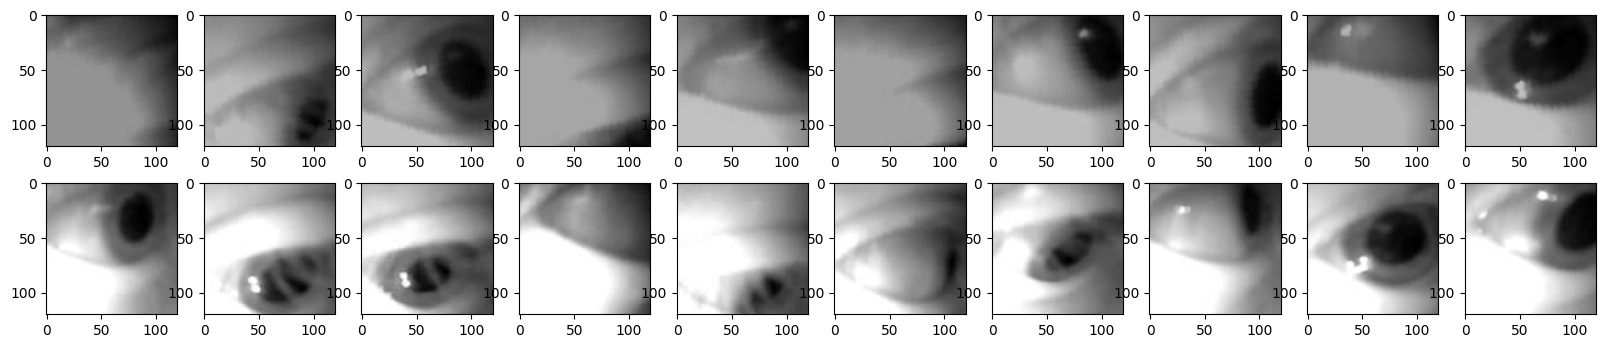

In [9]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, crop_size=(120, 120), crop_offset=(120,40), full_image=False):
        self.apply_random = True
        self.full_image = full_image
        self.root_dir = root_dir
        self.crop_size = crop_size
        self.crop_offset = crop_offset
        coords_dict = csv_to_dict(f'{root_dir}.csv')
        self.image_files, self.coords = zip(*coords_dict.items())
        self.coords = np.array(tuple((float(x[0]), float(x[1])) for x in self.coords), dtype=np.float32)
        # # Correction for latency
        # eps = 0.1
        # # Shift by this value to compensate for latency
        # lat_corr = 3
        # for i in range(len(self.coords)-1, -1, -1):
        #     if ((self.coords[i - lat_corr] - self.coords[i])**2).sum() < eps:
        #         self.coords[i] = self.coords[i - lat_corr]

        image_path = self.image_files[0]
        image = Image.open(image_path)
        width, height = image.size
        left = self.crop_offset[0]
        top = self.crop_offset[1]
        right = left + self.crop_size[0] + 20
        bottom = top + self.crop_size[1]+ 20
        
        self.transform = transforms.Compose([
            torch.tensor,
            transforms.RandomRotation(20, fill=0.7),
            crop_around_point,
            random_blur_brightness
            # transforms.RandomResizedCrop(self.crop_size, (0.1, 2.0), (1.0,1.0), antialias=False),
            # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0.7, inplace=False)
            # transforms.RandAugment(fill=0.7),
        ])
        
        

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        
        if isinstance(idx, int):
            idx = [idx]

        imgs = []
        for i in idx:
            image_path = self.image_files[i]
            image = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), (250,250)).reshape((1,1,250,250)).astype(np.float32) / 255
            # # image = Image.open(image_path)
            # image = image.convert('L')
            imgs.append(image)

        imgs = np.concatenate(imgs, axis=0)
        # print(imgs.shape)

        # Convert the image to a PyTorch tensor
        if self.apply_random:
            image_tensor = self.transform(imgs)
        elif self.full_image:
            image_tensor = torch.tensor(imgs)
            image_tensor = Ft.resize(image_tensor, (120, 120), antialias=False)
        else:
            width, height = 250, 250
            left = self.crop_offset[0]
            top = self.crop_offset[1]
            right = left + self.crop_size[0]
            bottom = top + self.crop_size[1]
            imgs = imgs[:,:,top:bottom,left:right]
            # image = image.crop((left, top, right, bottom)).resize((120, 120))
            image_tensor = torch.tensor(imgs)

        # print(image_tensor.shape)
        return image_tensor, torch.tensor(self.coords[idx])

    def do_random(self):
        self.apply_random = True

    def no_random(self):
        self.apply_random = False

dataset = ImageDataset(root_dir)

def rand_dataset_generator(length: int, batch_size: int=32):
    for x in list_sampler(length, batch_size):
        yield dataset[x]

def get_dataloader(dataset, batch_size=32):
    return LengthAwareGenerator(rand_dataset_generator, len(dataset), batch_size)


dataloader = get_dataloader(dataset, 64)
iterator = iter(dataloader)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
dataset.do_random()
imgs = next(iterator)[0]
for i, ax in enumerate(axes[0]):
    ax.imshow(imgs[i][0], cmap='gray', vmax=1.0)
dataset.no_random()
imgs = next(iterator)[0]
for i, ax in enumerate(axes[1]):
    ax.imshow(imgs[i][0], cmap='gray', vmax=1.0)
plt.show()

In [10]:
len(dataloader)

2195

In [11]:
print(1)

1


(-0.9122392296791076,
 0.9005620837211609,
 -1.1218845665454864,
 0.8784540712833404)

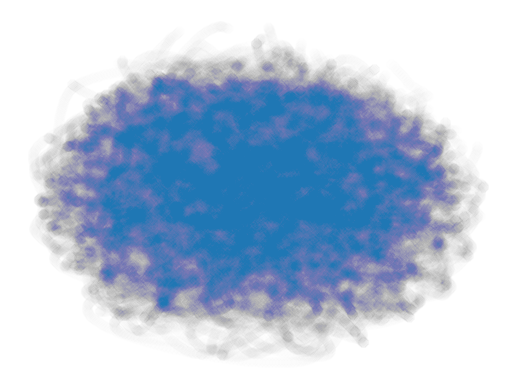

In [12]:
plt.scatter(dataset.coords[:,0], dataset.coords[:,1],50, alpha=0.003)
plt.axis('off')

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128*15*15, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128*15*15)
        x = self.fc1(x)
        return torch.sigmoid(x)

class VAE_GAN(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE_GAN, self).__init__()
        self.vae = VAE(latent_dim)
        self.discriminator = Discriminator()
        
    def forward(self, x):
        recon, mu, log_var = self.vae(x)
        d_real = self.discriminator(x)
        d_fake = self.discriminator(recon)
        return recon, mu, log_var, d_real, d_fake

    def compress(self, x):
        with torch.no_grad():
            x = x.to(device)
            mu, _ = self.vae.encode(x)
            comp = mu.cpu().numpy()
        return comp
    
    def reconstruct(self, comp):
        with torch.no_grad():
            z = torch.from_numpy(comp).to(device)  
            recon = self.vae.decode(z)
            recon = recon.cpu().numpy()
        return recon

In [14]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.vae = VAE()
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        if self.training:
            mu, var_log = self.vae.encode(x)
            x = self.vae.reparameterize(mu, var_log)
        else:
            x, _ = self.vae.encode(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.tanh(x) * 2
        
    def predict(self, x):
        with torch.no_grad():
            x = torch.tensor(x).to(device)
            x = self.forward(x)
            comp = x.cpu().numpy()
        return comp

In [84]:
def train(model, dataloader, img_compare=None, epochs=2000, lr=1e-3):
    dataset.do_random()
    optimizer_G = torch.optim.Adam(model.vae.parameters(), lr=lr)
    # optimizer_D = torch.optim.Adam(model.discriminator.parameters(), lr=1e-2)
    
    # Define the learning rate scheduler
    scheduler = StepLR(optimizer_G, step_size=1, gamma=0.9)
    
    rnd_str = ''.join(choices(ascii_letters,k=5))
    if hasattr(model, 'rnd_str'):
        rnd_str = model.rnd_str
    else:
        model.rnd_str = rnd_str
        os.mkdir(rnd_str)
        model.n_steps = 0
        
    if img_compare is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))
        ax1.axis('off')
        ax1.imshow(img_compare.numpy()[0], cmap='gray')
        ax2.axis('off')
        # ax2.imshow(model.reconstruct(model.compress(img_compare))[0,0], cmap='gray')
        display(fig, display_id=1)

    display('Waiting...', display_id=2)
    
    for epoch in range(epochs):
        sum_loss_recon = 0.0
        # sum_loss_kl = 0.0
        sum_loss_mmd = 0.0
        sum_loss_g = 0.0
        sum_loss_d = 0.0
        for i, (x, _) in enumerate(tqdm(dataloader)):
            x = x.to(device)
            
            # Train Generator (VAE)
            recon, mu, log_var, z = model.vae(x)
            recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
            # kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            mmd_loss = compute_mmd(z, torch.randn_like(z))
            
            # g_loss = F.binary_cross_entropy(d_fake, torch.ones_like(d_fake)) * 10
            # print(recon_loss.item(), kl_loss.item(), g_loss.item())
            vae_loss = recon_loss + mmd_loss #+ kl_loss #+ g_loss*100
            sum_loss_recon += recon_loss.item()
            # sum_loss_kl += kl_loss.item()
            sum_loss_mmd += mmd_loss.item()
            # sum_loss_g += g_loss.item()
            
            optimizer_G.zero_grad()
            vae_loss.backward(retain_graph=True)
            
            
            # Train Discriminator
            # d_loss_real = F.binary_cross_entropy(d_real, torch.ones_like(d_real))
            # d_loss_fake = F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
            # d_loss = d_loss_real + d_loss_fake     
            # sum_loss_d += d_loss.item()     
            
            # optimizer_D.zero_grad()
            # d_loss.backward()
            # optimizer_D.step()
            # optimizer_G.step()
            
            model.n_steps += 1

            model.history.append((vae_loss.item()))

            if i % 100 == 1:
                if img_compare is not None:
                    plt.close()
                    ax1.axis('off')
                    ax1.imshow(img_compare.numpy()[0], cmap='gray')
                    ax2.axis('off')
                    ax2.imshow(model.reconstruct(model.compress(img_compare))[0,0], cmap='gray')
                    update_display(fig, display_id=1)
                    fig.canvas.print_jpeg(f'{rnd_str}/{model.n_steps}.jpg')
                update_display(f"Epoch [{epoch+1}/{epochs}], VAE Loss: recon {sum_loss_recon/(i+1):.4f} kl {sum_loss_mmd/(i+1):.4f}, lr: {scheduler.get_last_lr()[0]}", display_id=2)


        scheduler.step()

In [15]:
device = 'cuda'
reg = Regressor().to(device)
# reg.load_state_dict(torch.load('

In [16]:
device = 'cuda'
model = VAE_GAN(latent_dim=32).to(device)
model.vae = reg.vae
model.history = []

In [17]:
model.load_state_dict(torch.load('VAE10mmd_hMwFi.pth'))

<All keys matched successfully>

132442


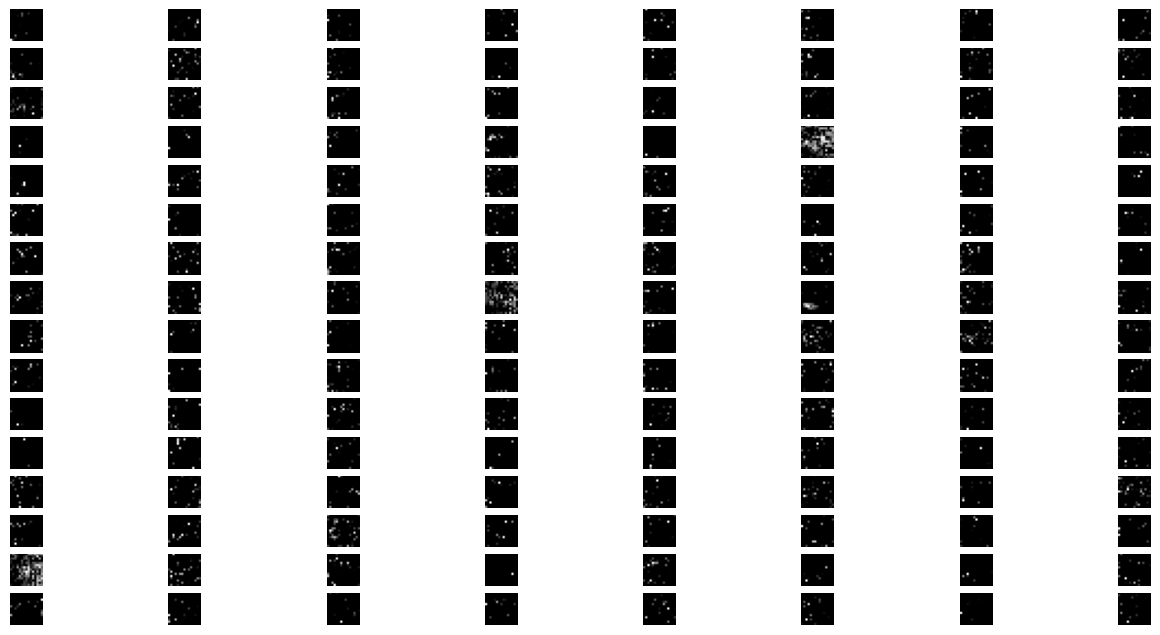

In [67]:
dataset.no_random()
idx = randint(0,len(dataset))
idx = 132442
img = dataset[idx][0].to(device)
print(idx)
with torch.no_grad():
    x = model.vae.reparameterize(*model.vae.encode(img))
    x = F.relu(model.vae.dec_fc1(x))
    x = x.view(-1, 128, 15, 15)
    # x = F.relu(model.vae.dec_conv1(x))
    # x = F.relu(model.vae.dec_conv2(x))
    # x = torch.sigmoid(model.vae.dec_conv3(x))
    feat = x.cpu().numpy()[0]

if feat.shape[0] == 1:
    plt.imshow(feat[0])
else:
    fig, axeses = plt.subplots(feat.shape[0]//8, 8, figsize=(16,8))
    for i, axes in enumerate(axeses):
        for j, ax in enumerate(axes):
            ax.axis('off')
            ax.imshow(feat[i * len(axes) + j], 'gray', resample=False)

# feat.shape
# plt.imshow(img[0][0], cmap='gray')

In [72]:
model.discriminator = Discriminator().to(device)

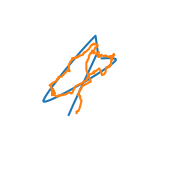

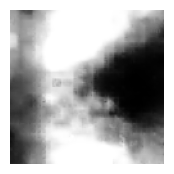

  1%|▌                                                                               | 14/2195 [00:03<09:33,  3.80it/s]


KeyboardInterrupt: 

In [87]:
# dataset.apply_random = False
img = dataset[randint(1,10000)][0][0]
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
# model.vae.training = True
dataloader = get_dataloader(dataset, 64)
train(model, dataloader, img, epochs=60, lr=5e-5)

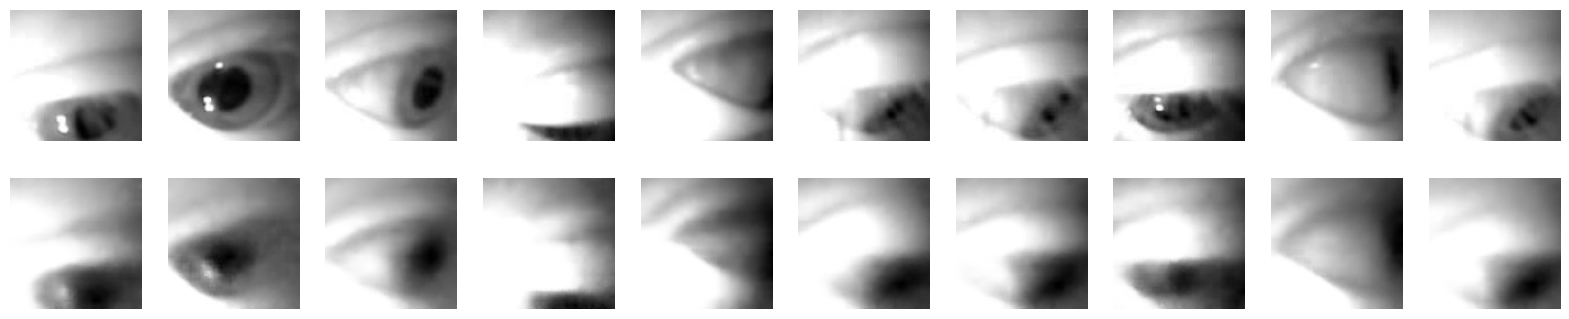

In [24]:
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
dataset.no_random()
for ax1, ax2 in zip(axes[0], axes[1]):
    img = dataset[randint(0, len(dataset)-1)][0]
    ax1.axis('off')
    ax1.imshow(img[0][0], cmap='gray')
    ax2.axis('off')
    ax2.imshow(model.reconstruct(model.compress(img))[0][0], cmap='gray')

In [99]:
torch.save(model.state_dict(), f'VAE10mmd_{model.rnd_str}.pth')

In [324]:
i = 0

48674
torch.Size([1, 1, 120, 120])


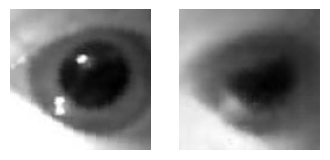

In [148]:
dataset.apply_random = True
idx = randint(0, len(dataset) - 1)
idx = 48671 + i
# i+=10
print(idx)
img_compare = dataset[idx][0]
print(img_compare.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))
ax1.axis('off')
ax1.imshow(img_compare.numpy()[0][0], cmap='gray')
ax2.axis('off')
latent = model.compress(img_compare)
ax2.imshow(model.reconstruct(latent)[0,0], cmap='gray')

In [ ]:
dataset.apply_random = True
latents = []
for batch, _ in tqdm(dataloader):
    latents.append(model.compress(batch))

In [150]:
# Concatenate the tensors into a single tensor
latents = np.concatenate(latents, axis=0)

latents.shape

(5824, 32)

In [151]:
# latent = model.compress(dataset[48671])
lat = latent[0]
# 14362
# 14482
lat

array([ 2.0598557 , -6.0205884 , -2.4028473 ,  0.49477917,  0.45990524,
       -0.37844765,  1.0941544 , -2.0565352 ,  2.2088466 , -1.638473  ,
       -3.1017265 , -0.30847615,  0.38635147, -0.8022202 ,  1.9390464 ,
       10.972438  , -0.7670444 , -1.874599  , -4.1749883 ,  2.040114  ,
       -1.7833484 ,  4.5717587 , 10.951763  ,  3.3238835 , -2.847236  ,
       -1.3009751 ,  3.2994578 , -2.0378952 ,  2.1598551 , -0.41572285,
        0.56076646, 56.41725   ], dtype=float32)

[37.56436933 -7.15463585 -0.11977455  3.07833321 -3.96746674  5.14260142
  2.0705963  -0.67232431  1.76976317 -1.91854023 -0.98115672 -1.39347439
  0.79015745  0.91736462  0.52877098  0.04818275]


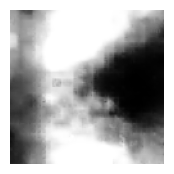

In [153]:
n_sliders = 16
pca = PCA(n_components=n_sliders)
pca.fit(latents)
slider_limit = 40
compressed_lat = pca.transform([lat])[0]
print(compressed_lat)
sliders = [widgets.FloatSlider(value=compressed_lat[i], min=-slider_limit, max=slider_limit, step=0.01, description=f"{i}") for i in range(n_sliders)]

output_box = widgets.Output()
def on_slider_change(change):
    with output_box:
        input_vector = np.array([[slider.value for slider in sliders]], dtype=np.float32)
        input_vector = pca.inverse_transform(input_vector)
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        ax.axis('off')
        ax.imshow(model.reconstruct(input_vector)[0,0], cmap='gray')
        update_display(fig, display_id=2)

for slider in sliders:
    slider.observe(on_slider_change, names='value')

in_row = 4
layout = widgets.VBox([
    *[widgets.HBox(sliders[in_row * i:in_row * (i+1)]) for i in range(n_sliders)],
    output_box
])

# Display the widget
display(layout)
display('', display_id=2)
None

In [155]:
def show_diff(reg, imgs_compare, coords_compare, fig=None, ax=None, display_id=None):
    try:
        iter(ax)
    except:
        ax = [ax]
        imgs_compare = [imgs_compare]
        coords_compare = [coords_compare]

    for i, ax1 in enumerate(ax):
        if display_id is None:
            fig, ax1 = plt.subplots(1, 1, figsize=(2, 2))
        else:
            plt.close()
            ax1.cla()
        ax1.axis('off')
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        pred = reg.predict(imgs_compare[i])
        # for a, b in zip(coords_compare, pred):
        #     ax.plot([a[0], b[0]], [a[1], b[1]], 'r')
        ax1.plot(coords_compare[i][:,0], coords_compare[i][:,1])
        ax1.plot(pred[:,0], pred[:,1])
    if display_id is None:
        display(fig, display_id=1)
    else:
        update_display(fig, display_id=display_id)
        # fig.canvas.print_jpeg(f'reg_{rnd_str}_{epoch}_{i}.jpg')
    return fig, ax1

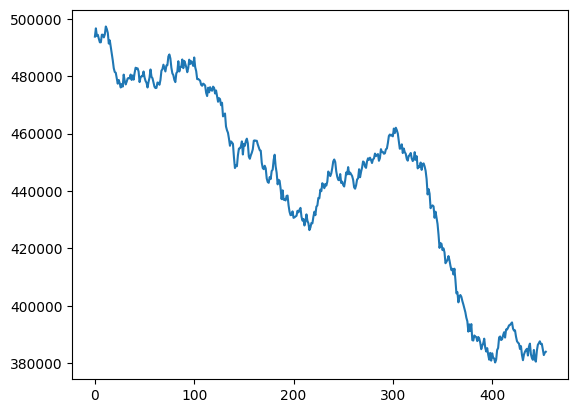

In [158]:
window_size = 100
moving_average = np.convolve([x if isinstance(x,float) else x[0] for x in model.history if (x if isinstance(x,float) else x[0]) > 100000], np.ones(window_size, dtype=int), 'valid') / window_size
plt.plot(moving_average)

In [159]:
def train_regressor(model: Regressor, dataloader: DataLoader, imgs_compare=None, coords_compare=None, epochs=2000, lr=1.0e-3):
    # dataloader.dataset.apply_random = True
    
    optimizer_R = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Define the learning rate scheduler
    scheduler = StepLR(optimizer_R, step_size=1, gamma=0.8)

    display('', display_id='reg_status')
    
    if imgs_compare is not None:
        fig, ax = show_diff(model, imgs_compare, coords_compare)

    rnd_str = ''.join(choices(ascii_letters,k=5))
    if hasattr(model, 'rnd_str'):
        rnd_str = model.rnd_str
    else:
        model.rnd_str = rnd_str
        os.mkdir(f'{model.rnd_str}_paths')
        model.history = []
        model.n_steps = 0

    last_sum = 0
    for epoch in range(epochs):
        sum_loss = 0
        for i, (x, y) in enumerate(tqdm(dataloader)):
            x, y = x.to(device), y.to(device)
            
            # with torch.no_grad():
            #     mu, log_var = vae.encode(x)
            #     x = vae.reparameterize(mu, log_var)
            
            prediction = model(x)
            loss = F.mse_loss(prediction, y.view((-1,2)))
            sum_loss += loss.item()
            
            optimizer_R.zero_grad()
            loss.backward(retain_graph=True)
            optimizer_R.step()
            model.history.append(loss.item())
            

            if i % 100 == 1:
                if imgs_compare is not None:
                    show_diff(model, imgs_compare, coords_compare, fig, ax, 1)
                    fig.canvas.print_jpeg(f'{model.rnd_str}_paths/{model.n_steps}.jpg')
                update_display(f"Epoch [{epoch+1}/{epochs}], MSE Loss: {sum_loss/i:.4f} (curr: {(sum_loss-last_sum)/100:.4f}) , lr: {scheduler.get_lr()}", display_id='reg_status')
                
                last_sum = sum_loss
        scheduler.step()
                    
                    
        
        # print(f"Epoch [{epoch+1}/{epochs}], MSE Loss: {sum_loss/i:.4f}")

In [160]:
device = 'cuda'
reg = Regressor().to(device)
# reg.vae.load_state_dict(model.vae.state_dict())

In [165]:
reg.load_state_dict(torch.load('Reg9_SiVQB.pth'))

<All keys matched successfully>

'Epoch [1/2000], MSE Loss: 0.0157 (curr: 0.0002) , lr: [5e-07]'

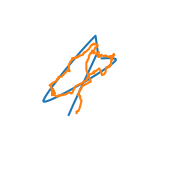

  6%|████▌                                                                           | 62/1098 [00:30<08:28,  2.04it/s]


KeyboardInterrupt: 

In [169]:
dataset.do_random()

dataloader = get_dataloader(dataset, batch_size=128)
train_regressor(reg, dataloader, imgs_compare[0], coords_compare[0], lr=0.0000005)

In [167]:
import warnings
warnings.filterwarnings("ignore")

In [178]:
dataset.apply_random = True
length = 300
starts = [randint(0, len(dataset) - length - 1) for _ in range(10)]
imgs_compare = []
coords_compare = []
for start in tqdm(starts):
    imgs, coords = dataset[list(range(start,start + length))]
    imgs_compare.append(imgs)
    coords_compare.append(coords)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.04it/s]


In [113]:
coords_compare.shape

torch.Size([1000, 2])

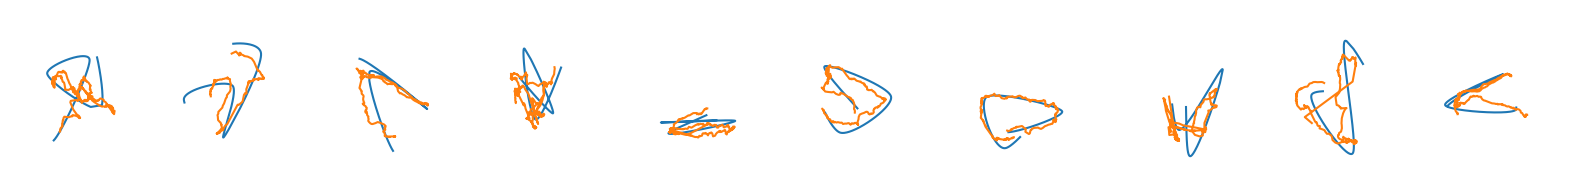

In [180]:
fig, axes = plt.subplots(1, 10, figsize=(20,2))
display('', display_id='check_reg')
show_diff(reg, imgs_compare, coords_compare, fig, axes, display_id='check_reg')
None

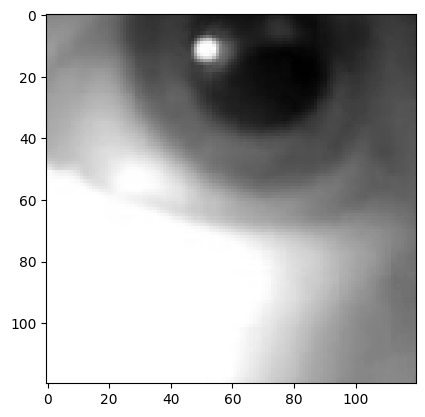

In [87]:
plt.imshow(imgs_compare[9][0][0], cmap='gray')

In [92]:
torch.save(reg.state_dict(), f'Reg10_{reg.rnd_str}.pth')

In [186]:
dataset_test = ImageDataset(r"C:\Users\anpro\dataset\EyeTracking\test")
dataloader_test = get_dataloader(dataset_test)

In [187]:
def mse_loss(pred, actual):
    return ((pred - actual) ** 2).mean()

In [182]:
from blob import BLOB

In [226]:
class BlobSettings:
    def __init__(self, threshold: int):
        self.gui_threshold: int = threshold
        self.gui_blob_minsize = 10
        self.gui_blob_maxsize = 90

class BlobHandler:
    def __init__(self, threshold):
        self.current_image_gray: np.ndarray
        self.settings = BlobSettings(threshold)
        self.failed = 0

        # for calibration
        self.xlim = [1000, 0]
        self.ylim = [1000, 0]

    def transform(self, coord):
        return (coord[0] - self.ylim[0]) / (self.ylim[1] - self.ylim[0] + 0.0001),\
               (coord[1] - self.xlim[0]) / (self.xlim[1] - self.xlim[0] + 0.0001)

blob_handler = BlobHandler(110)

def calibrate_blob(blob_handler, coord):
    if coord[1] > blob_handler.xlim[1]:
        blob_handler.xlim[1] = coord[1]
    if coord[1] < blob_handler.xlim[0]:
        blob_handler.xlim[0] = coord[1]
    if coord[0] > blob_handler.ylim[1]:
        blob_handler.ylim[1] = coord[0]
    if coord[0] < blob_handler.ylim[0]:
        blob_handler.ylim[0] = coord[0]

def blob(imgs):
    coords = []
    for img in imgs:
        blob_handler.current_image_gray = (img.cpu().numpy()[0] * 255).astype(np.uint8)
        coord = BLOB(blob_handler)[:2]
        if coord != (0, 0):
            calibrate_blob(blob_handler, coord)
        coords.append(coord if coord[0] == 0 else blob_handler.transform(coord))
    return np.array(coords) * 2 - 1

In [227]:
algorithms = {
    'SVAE': reg.predict,
    'blob': blob,
}

In [234]:
dataset_test.no_random()

for name, predict in algorithms.items():
    loss_sum = 0
    if name == 'blob':
        dataset.full_image = True
    for X, y in tqdm(dataloader_test):
        pred = predict(X)
        pred_cut, y_cut = (pred[pred[:,0]!=-1], y[pred[:,0]!=-1])
        loss = mse_loss(pred_cut, y_cut.cpu().numpy())
        loss_sum += loss

    if name == 'blob':
        dataset.full_image = False
        
    print(f"Algorithm {name} loss: {loss_sum / len(dataloader_test):.4f}")
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [00:17<00:00, 19.06it/s]


Algorithm SVAE loss: 0.0089


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [00:14<00:00, 22.46it/s]

Algorithm blob loss: 0.2236


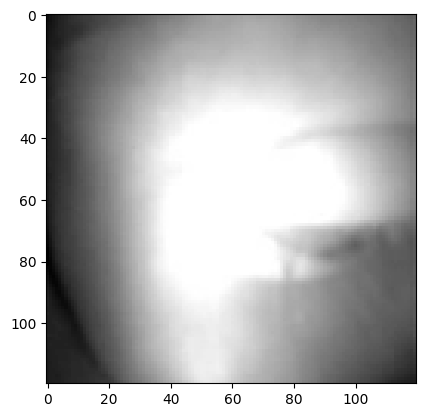

In [241]:
dataset.full_image = True
plt.imshow(dataset[0][0][0,0], cmap='gray')
dataset.full_image = False

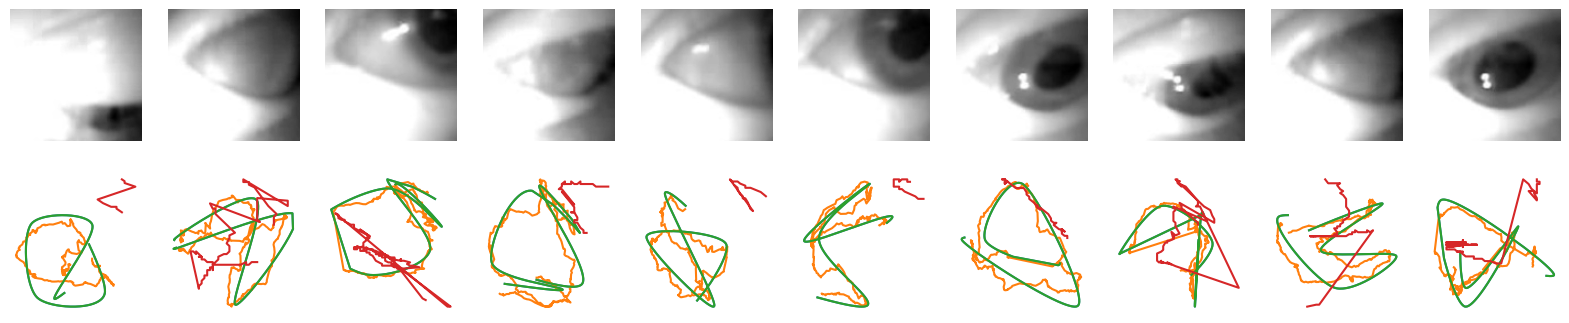

In [243]:
dataset_test.no_random()
length = 400
fig, axes = plt.subplots(2,10, figsize=(20,4))
for name, predict in algorithms.items():
    if name == 'blob':
        dataset.full_image = True
    for i, (ax1, ax2) in enumerate(zip(*axes)):
        imgs_test, coords_test = dataset_test[list(range(i * 1000, i * 1000 + length))]
        ax1.axis('off')
        ax1.imshow(imgs_test[0][0], cmap='gray')
        ax2.axis('off')
        ax2.plot(coords_test[:,0], coords_test[:,1])
        pred = predict(imgs_test)
        ax2.plot(*pred[pred[:,0] != -1].T)
    if name == 'blob':
        dataset.full_image = False


In [233]:
pred[pred[:,0] != -1]

array([[-0.10769368, -0.08000092],
       [-0.16923205, -0.08000092],
       [-0.10769368, -0.08000092],
       [-0.16923205, -0.08000092],
       [-0.20000123, -0.08000092],
       [-0.20000123, -0.08000092],
       [-0.20000123, -0.08000092],
       [-0.20000123, -0.08000092],
       [-0.20000123, -0.08000092],
       [-0.38461633, -0.08000092],
       [-0.20000123, -0.08000092],
       [-0.38461633, -0.08000092],
       [-0.23077041, -0.08000092],
       [-0.23077041, -0.08000092],
       [-0.41538551, -0.1000009 ],
       [-0.41538551, -0.08000092],
       [-0.23077041, -0.08000092],
       [-0.23077041, -0.06000094],
       [-0.23077041, -0.08000092],
       [-0.2615396 , -0.06000094],
       [-0.2615396 , -0.08000092],
       [-0.2615396 , -0.06000094],
       [-0.4461547 , -0.08000092],
       [-0.2615396 , -0.08000092],
       [-0.2615396 , -0.04000096],
       [-0.2615396 , -0.1000009 ],
       [-0.2615396 , -0.08000092],
       [-0.2615396 , -0.08000092],
       [-0.23077041,

In [23]:
def bezier_interp4(x1, y1, x2, y2, x3, y3, x4, y4, pos):
    c1 = bezier_interp3(x1, y1, x2, y2, x3, y3, 0.5 + pos / 2)
    c2 = bezier_interp3(x2, y2, x3, y3, x4, y4, pos / 2)
    return c1[0] * (1 - pos) + c2[0] * pos, c1[1] * (1 - pos) + c2[1] * pos

def bezier_interp3(x1, y1, x2, y2, x3, y3, pos):
    dx1 = x1 + 2 * (x2 - x1) * pos
    dx2 = x2 + (x2 - x3) + 2 * (x3 - x2) * pos
    dy1 = y1 + 2 * (y2 - y1) * pos
    dy2 = y2 + (y2 - y3) + 2 * (y3 - y2) * pos
    return dx1 * (1 - pos) + dx2 * pos, dy1 * (1 - pos) + dy2 * pos

In [66]:
def generate_point(last_point, FOW_CENTER_X, FOW_CENTER_Y, FOW_HALF_WIDTH, FOW_HALF_HEIGHT):
    dx, dy = 1000, 1000
    tmpx = (dx - FOW_CENTER_X) / FOW_HALF_WIDTH  # Normalized distance from center
    tmpy = (dy - FOW_CENTER_Y) / FOW_HALF_HEIGHT
    tmpsx = (dx - last_point[0]) / FOW_HALF_WIDTH  # Normalized distance from last point
    tmpsy = (dy - last_point[1]) / FOW_HALF_HEIGHT
    while tmpx ** 2 + tmpy ** 2 >= 1.0 or tmpsx ** 2 + tmpsy ** 2 < 0.3:
        dx = np.random.uniform(-FOW_HALF_WIDTH, FOW_HALF_WIDTH)
        dy = np.random.uniform(-FOW_HALF_HEIGHT, FOW_HALF_HEIGHT)
        tmpx = (dx - FOW_CENTER_X) / FOW_HALF_WIDTH
        tmpy = (dy - FOW_CENTER_Y) / FOW_HALF_HEIGHT
        tmpsx = (dx - last_point[0]) / FOW_HALF_WIDTH
        tmpsy = (dy - last_point[1]) / FOW_HALF_HEIGHT
    return dx, dy

DOT_SPEED = 0.01
def generate_smooth_line(FOW_CENTER_X, FOW_CENTER_Y, FOW_HALF_WIDTH, FOW_HALF_HEIGHT):
    points = []
    for i in range(4):
        points.append(generate_point((-1000, -1000), FOW_CENTER_X, FOW_CENTER_Y, FOW_HALF_WIDTH, FOW_HALF_HEIGHT))
    x, y = points[1]
    dx, dy = points[2]
    dist = np.sqrt((dx - x) ** 2 + (dy - y) ** 2)
    iters = int(dist / DOT_SPEED)
    v = 1.0 / iters
    pstate = 0.0

    while True:
        yield bezier_interp4(
            *points[0], *points[1], *points[2], *points[3], pstate
        )

        pstate += v
        if pstate >= 1.0:
            points.pop(0)
            points.append(generate_point(points[-1], FOW_CENTER_X, FOW_CENTER_Y, FOW_HALF_WIDTH, FOW_HALF_HEIGHT))
            x, y = points[1]
            dx, dy = points[2]
            dist = np.sqrt((dx - x) ** 2 + (dy - y) ** 2)
            iters = int(dist / DOT_SPEED)
            v = 1.0 / iters
            pstate = 0.0

In [70]:
len()

140417

(-0.19924529897226165,
 0.9264425845085396,
 -0.5241050754289741,
 0.5838372641607137)

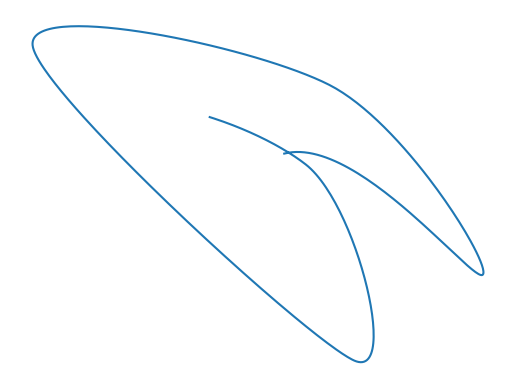

In [211]:
generator = generate_smooth_line(0.0, -0.2, 0.9, 0.7)
curve = np.array([next(generator) for _ in range(400)])[1:]
plt.plot(*curve.T)
plt.axis('off')

In [91]:
folder = r'C:\Users\anpro\code\Diplom\iWxkn'
img_files = sorted(os.listdir(folder), key=lambda x: int(x.split('.')[0]))

In [121]:
len(img_files)

825

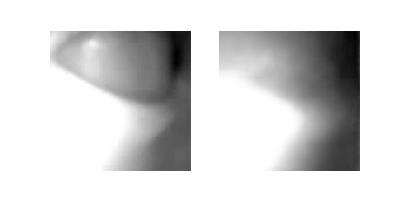

In [125]:
im = Image.open(os.path.join(folder,img_files[800]))
im

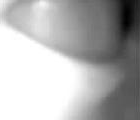

In [138]:
im.crop((50,40,190,160))

In [106]:
to_connect = []

In [52]:
class ResidualLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.resample = None
        if in_channels != out_channels:
            self.resample = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        if self.resample:
            residual = self.resample(x)
        out += residual
        out = self.relu(out)
        return out

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers):
        super(ResidualStack, self).__init__()
        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList([ResidualLayer(in_channels, num_hiddens) for _ in range(num_residual_layers)])
        
    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return x

In [58]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.commitment_cost = commitment_cost
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self.embedding.weight.shape[1])
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

class VQ_VAE(nn.Module):
    def __init__(self, num_hiddens, num_embeddings, embedding_dim, commitment_cost, num_residual_layers):
        super(VQ_VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, num_hiddens//2, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_hiddens//2, num_hiddens, 4, 2, 1),
            nn.ReLU(inplace=True),
            ResidualStack(num_hiddens, num_hiddens, num_residual_layers),
        )
        
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, 
                                        commitment_cost)
        
        self.decoder = nn.Sequential(
            ResidualStack(embedding_dim, embedding_dim, num_residual_layers),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(embedding_dim, num_hiddens, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(num_hiddens, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        z_e = self.encoder(x)
        loss, quantized, perplexity, _ = self.vq_layer(z_e)
        return loss, quantized, perplexity
    
    def decode(self, latent_code):
        z_q = self.vq_layer.embedding(latent_code)
        x_recon = self.decoder(z_q)
        return x_recon

    def forward(self, x):
        z_e = self.encoder(x)
        print(z_e.shape)
        loss, z_q, perplexity, _ = self.vq_layer(z_e)
        print(z_q.shape)
        x_recon = self.decoder(z_q)
        return loss, x_recon, perplexity

In [59]:
num_hiddens = 128
num_embeddings = 512 
embedding_dim = 48
commitment_cost = 0.25
num_residual_layers = 4
learning_rate = 1e-3

In [60]:
device = 'cuda'
model = VQ_VAE(num_hiddens, num_embeddings, embedding_dim, commitment_cost, num_residual_layers).to(device)

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
def visualize_reconstruction(original_image, reconstructed_image, epoch, step, update_interval=10, display_id='nya'):
    if step % update_interval == 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        
        # Plot original image
        ax1.imshow(original_image.cpu().squeeze().numpy(), cmap='gray')
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        # Plot reconstructed image
        ax2.imshow(reconstructed_image.cpu().detach().squeeze().numpy(), cmap='gray')
        ax2.set_title(f"Epoch: {epoch+1}, Step: {step+1}")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show(block=False)
        plt.pause(0.1)
        plt.close()

In [62]:
num_epochs = 100
update_interval = 10
dataloader = get_dataloader(dataset)
for epoch in range(num_epochs):
    for x, _ in dataloader:
        x = x.to(device)
        vq_loss, x_recon, perplexity = model(x)
        recon_loss = F.mse_loss(x_recon, x)
        loss = recon_loss + vq_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % update_interval == 0:
            visualize_reconstruction(x[0], x_recon[0], epoch, step, update_interval)
        
        step += 1

torch.Size([32, 128, 30, 30])
torch.Size([32, 128, 30, 30])


RuntimeError: Given groups=1, weight of size [48, 48, 3, 3], expected input[32, 128, 30, 30] to have 48 channels, but got 128 channels instead

In [79]:
def nanka(n):
    for i in range(n):
        yield i

s = nanka(5)

In [86]:
next(s)

StopIteration: 